# Markov Matricies and Asset Prices

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

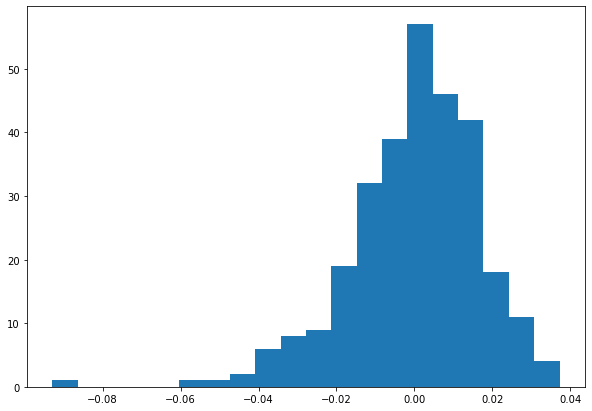

In [2]:
df = pd.read_csv("GDP_cycle.csv")

#Plot histogram of data
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(df.cycle, bins=20)
plt.show()

In [3]:
#sort data by value
cycle = np.array(df.cycle.sort_values( ascending = True))
#split data into quartiles and compute exp of the mean
c0 = math.exp(np.mean(cycle[0:74]))
c1 = math.exp(np.mean(cycle[74:148]))
c2 = math.exp(np.mean(cycle[148:222]))
c3 = math.exp(np.mean(cycle[222:296]))
#put everything into consumption vector
c = np.array([c0, c1, c2, c3])
c #Check to see if consumption vector is the same as Fisher

array([0.97846196, 0.99664606, 1.00620004, 1.01913278])

In [4]:
#Assign each period to a quartile
q=[]
for i in df.cycle:
    if i<-0.0087221999962601:
        q.append(0)
    elif -0.0087221999962601 <= i < 0.0009428081518567:
        q.append(1)
    elif 0.0009428081518567 <= i < 0.0113638256779982:
        q.append(2)
    elif i >=0.0113638256779982:
        q.append(3)
q = np.array(q)
q[0:17] #Check to see if the quartiles are the same as Fisher's

array([3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3])

In [5]:
M_count=np.zeros([4,4])
#Find the count in each row
for i in range(len(q)-1):
    M_count[q[i]][q[i+1]] = M_count[q[i]][q[i+1]] + 1
M_count

array([[57., 13.,  4.,  0.],
       [13., 44., 16.,  1.],
       [ 2., 16., 37., 19.],
       [ 2.,  1., 17., 53.]])

In [6]:
#Estimate Markov matrix
sums = M_count.sum(axis=1)
M = M_count/sums[:, np.newaxis]
M

array([[0.77027027, 0.17567568, 0.05405405, 0.        ],
       [0.17567568, 0.59459459, 0.21621622, 0.01351351],
       [0.02702703, 0.21621622, 0.5       , 0.25675676],
       [0.02739726, 0.01369863, 0.23287671, 0.7260274 ]])

In [7]:
def ergodic(m):
    """
    This code finds the ergodic distribution of a Markov matrix
    """
    n=m.shape[0] # number of rows
    T = 1000 # useful constant
    eps=0.0001 #useful constant
    if (m.shape[0] != m.shape[1]): #test for a square matrix
        return('Matrix is not square') 
    if (not (np.matmul(m,np.ones(n))==1).all()): #test row sums 
        return('This is not a Markov matrix')
    if( not ((m >= 0).all() and (m <= 1).all())): #test probabilities
        return('This is not a Markov matrix')
    m_long = np.linalg.matrix_power(m,T)
    if( not ((m_long > 0).all() and (m_long < 1).all())): #crude test for aperiodic and irreducible
        return('This matrix may not be both aperiodic and irreducible')
    w,v = np.linalg.eig(m.T) #Need the left eigenvector; that's why we transpose
    choose = (abs(w-1) < eps)
    m_long = v[:,choose]/sum(v[:,choose])  #Need to make the eigenvector into a probability vector.
    return(m_long)

In [8]:
#This is the code from 28 Jan 21
# There's no β here.
# This function is used for each row.

def kern(c0,c1,rho):
    """
    This function returns an asset pricing kernel 
    c0 is current consumption
    c1 is the vector of future consumptions
    rho is the inter-temporal elasticity of substitution
    """
    if rho == 1:
        return np.true_divide(1,c1)/(1/c0) 
    else: 
        return np.power(c1,-rho)/c0**(-rho)
    

def mkern(c,beta,rho):
    n = len(c) # number of states
    K=np.zeros((n,n)) # start with an array of zeros
    for i in range (n):
        K[i,:] = beta*kern(c[i],c,rho)  # each row is an asset pricing kernel for consumption in state i
    return(K)
        

In [9]:
# Now I can price assets

def pricing(M,K,R):
    """
    M is a markov matrix
    K is a pricing kernel
    R is a matrix of asset payouts.
    The asset returns are by column
    """
    if M.shape != K.shape:
        return('Markov matrix and pricing kernels are not conformable.')
    if M.shape[1] != R.shape[0]:
        return('Asset price matrix is not conformable.')
    P = np.matmul(np.multiply(M,K), R)  
    # element by element multiplication of the pricing kernel with the markov probabilities
    return(P)

In [10]:
# need all of these constants
beta=0.97**(1/4)
rho=2

R = np.array([[1, 1, 1,1]]).T

K=mkern(c,beta,rho)
p=pricing(M,K,R)
p

array([[0.98319342],
       [0.99431365],
       [0.99166405],
       [1.0013209 ]])

In [11]:
interest_rate = np.power((1/p),4)
interest_rate #check my work

array([[1.07014876],
       [1.02307246],
       [1.03405044],
       [0.99473378]])

In [12]:
print('The average long-run interest rate is', np.dot(ergodic(M).T,interest_rate)[0][0])

The average long-run interest rate is 1.030622606397559
